In [2]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from keras.models import load_model

Record the result 

https://shimo.im/docs/89HGjyWXqHjv6kt9

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Museum_vis

Mounted at /content/drive/
/content/drive/My Drive/Museum_vis


In [4]:
"""
之前是网络训练100个周期
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

每次网络训练1个周期，循环执行100次，每次循环重置网络状态
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))
model.predict(trainX, batch_size=batch_size)
"""
# 将数据截取成3个一组的监督学习格式
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, :])
	return numpy.array(dataX), numpy.array(dataY)


In [5]:
f = numpy.load('test.npy', allow_pickle=True)
sequence = []
for i in f:
  for j in i:
    sequence.append(j)

In [6]:
value_6 = []
value_7 = []
value_8 = []
for i in sequence:
  if len(i) == 8:
    value_6.append(i[5])
  if len(i) >= 7:
    value_7.append(i[4])
  elif len(i) >= 6:
    value_8.append(i[3])
compute_mean = [numpy.mean(value_6),numpy.mean(value_7),numpy.mean(value_8)]

In [7]:
compute_mean

[349.40776699029124, 52.371108343711086, 205.34299325129018]

In [8]:
count = 0
sequence2 = []
max_len = 8
for i in sequence:
  # print(i)
  if len(i)==5:
    i[3:3] = compute_mean
  elif len(i)==6:
    i[4:4] = compute_mean[1:]
  elif len(i)==7:
    i[5:5] = compute_mean[2:]
  # print(i,"\n")
  sequence2.append(numpy.array(i[2:]))
dataset2 = numpy.array(sequence2)
print(dataset2[:5])
max_value = dataset2.max(axis=0)
min_value = dataset2.min(axis=0)
dataset2 = dataset2/(dataset2.max(axis=0)-dataset2.min(axis=0))
# print(dataset2[:5]*(max_value-min_value))
# dataset2 = dataset2.reshape([len(dataset2),8])


[[ 50.         349.          52.37110834 205.34299325   7.
   15.        ]
 [ 50.         332.          52.37110834 205.34299325   7.
   15.        ]
 [ 50.         349.          52.37110834 205.34299325   7.
   15.        ]
 [105.          17.          52.37110834 205.34299325   7.
   15.        ]
 [ 93.          50.          52.37110834 205.34299325   7.
   15.        ]]


In [9]:
max_value

array([487., 679., 581., 640.,  22.,  30.])

In [10]:
# 分割2/3数据作为测试
train_size = int(len(dataset2) * 0.8)
test_size = len(dataset2) - train_size
train, test = dataset2[0:train_size,:], dataset2[train_size:len(dataset2),:]
print(train[0])
print(test[0])
# 预测数据步长为3,三个预测一个，3->1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 重构输入数据格式 [samples, time steps, features] = [93,3,1]
#trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))


[0.03369272 0.18633209 0.08998472 0.34981771 0.41176471 0.625     ]
[0.00067385 0.1865498  0.08998472 0.34981771 0.29411765 0.625     ]


In [11]:
numpy.save('testX.npy',testX)

In [12]:
print(len(trainX))
print(len(trainX[0]))
print(trainX.shape)
print(trainX[0].shape)
print(trainX[0])

4159
3
(4159, 3, 6)
(3, 6)
[[0.03369272 0.18633209 0.08998472 0.34981771 0.41176471 0.625     ]
 [0.03369272 0.17725574 0.08998472 0.34981771 0.41176471 0.625     ]
 [0.03369272 0.18633209 0.08998472 0.34981771 0.41176471 0.625     ]]


In [15]:

# 构建 LSTM 网络
output_size = trainX[0].shape[1]
batch_size = 1
model = Sequential()
model.add(Bidirectional(LSTM(10, batch_input_shape=(batch_size, look_back, output_size), stateful=True, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(10, stateful=True, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(output_size))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:

# 网络训练一个周期，循环训练100次
for i in range(100):
    #shuffle=False训练时不打数据乱顺序
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    # 每次训练完都重置网络状态
	model.reset_states()

'''
# 对数据进行逆缩放
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

'''

4159/4159 - 17s - loss: 0.0411
4159/4159 - 11s - loss: 0.0303
4159/4159 - 11s - loss: 0.0279
4159/4159 - 11s - loss: 0.0264
4159/4159 - 11s - loss: 0.0252
4159/4159 - 11s - loss: 0.0251
4159/4159 - 11s - loss: 0.0245
4159/4159 - 11s - loss: 0.0245
4159/4159 - 10s - loss: 0.0240
4159/4159 - 11s - loss: 0.0239
4159/4159 - 11s - loss: 0.0241
4159/4159 - 11s - loss: 0.0236
4159/4159 - 11s - loss: 0.0238
4159/4159 - 11s - loss: 0.0239
4159/4159 - 11s - loss: 0.0236
4159/4159 - 10s - loss: 0.0235
4159/4159 - 11s - loss: 0.0235
4159/4159 - 11s - loss: 0.0235
4159/4159 - 11s - loss: 0.0233
4159/4159 - 11s - loss: 0.0231
4159/4159 - 11s - loss: 0.0232
4159/4159 - 11s - loss: 0.0232
4159/4159 - 11s - loss: 0.0231
4159/4159 - 11s - loss: 0.0233
4159/4159 - 11s - loss: 0.0230
4159/4159 - 10s - loss: 0.0230
4159/4159 - 11s - loss: 0.0228
4159/4159 - 11s - loss: 0.0231
4159/4159 - 11s - loss: 0.0231
4159/4159 - 11s - loss: 0.0228
4159/4159 - 10s - loss: 0.0229
4159/4159 - 11s - loss: 0.0225
4159/415

'\n# 对数据进行逆缩放\ntrainPredict = scaler.inverse_transform(trainPredict)\ntrainY = scaler.inverse_transform([trainY])\ntestPredict = scaler.inverse_transform(testPredict)\ntestY = scaler.inverse_transform([testY])\n\n'

In [ ]:
model.save('LSTM_V1.h5')

In [ ]:
model = load_model('LSTM_V1.h5')

In [ ]:
batch_size = 1
# 对训练数据的Y进行预测
trainPredict = model.predict(trainX, batch_size=batch_size)
# 重置网络状态
model.reset_states()
# 对测试数据的Y进行预测
testPredict = model.predict(testX, batch_size=batch_size)

In [ ]:
print(trainPredict[:5])
print(trainY[:5])

[[0.0513432  0.10213919 0.1113784  0.33407113 0.69736016 1.0061437 ]
 [0.06884746 0.10759119 0.10568397 0.34173065 0.5646659  1.0102836 ]
 [0.08432139 0.08531538 0.09760459 0.31312156 0.7446487  1.0296421 ]
 [0.09572391 0.10773546 0.07990868 0.2868654  1.0656543  1.1778606 ]
 [0.10022546 0.11855552 0.11994652 0.32623395 0.75994885 1.1608372 ]]
[[0.07075472 0.00907635 0.09714419 0.34272172 1.         1.06666667]
 [0.06266846 0.02669514 0.09714419 0.34272172 1.         1.06666667]
 [0.15431267 0.00907635 0.09714419 0.34272172 1.         1.06666667]
 [0.03638814 0.10624666 0.09714419 0.34272172 1.         1.06666667]
 [0.03638814 0.11532301 0.09714419 0.34272172 1.         1.06666667]]


In [ ]:
def find_closed(number_list, value):
  min_value = 10000
  closest = 0
  for i in number_list:
    a = abs(i-value)
    if a<min_value:
      closest = i
      min_value = a
  return closest


In [ ]:
trainPredict_org = trainPredict*(max_value-min_value)
trainY_org = trainY*(max_value-min_value)
testPredict_org = testPredict*(max_value-min_value)
testY_org = testY*(max_value-min_value)
for i in range(10):
  print(trainPredict_org[i])
  print(trainY_org[i])

[ 76.19331264 191.30670257  64.82222968 196.09975305  13.94720316
  15.09215534]
[105.          17.          56.53791637 201.17765168  20.
  16.        ]
[102.1696344  201.51829783  61.50806907 200.59589404  11.29331827
  15.15425384]
[ 93.          50.          56.53791637 201.17765168  20.
  16.        ]
[125.13293847 159.79571418  56.80587003 183.8023541   14.8929739
  15.44463158]
[229.          17.          56.53791637 201.17765168  20.
  16.        ]
[142.05428559 201.78852124  46.50685403 168.38999754  21.31308556
  17.66790926]
[ 54.         199.          56.53791637 201.17765168  20.
  16.        ]
[148.73458785 222.05448148  69.80887292 191.49933055  15.19897699
  17.4125576 ]
[ 54.         216.          56.53791637 201.17765168  20.
  16.        ]
[ 85.74867862 211.92780201  64.35851674 196.61715451  12.73141146
  15.56093216]
[ 74.          83.          56.53791637 201.17765168  20.
  16.        ]
[ 97.14351928 192.24545121  61.2116265  196.99864537  11.93429947
  15.136669

Train Score: 93.88 RMSE
Test Score: 107.64 RMSE


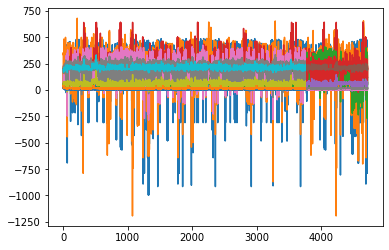

In [ ]:
# 计算RMSE误差
trainScore = math.sqrt(mean_squared_error(trainY_org, trainPredict_org))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_org, testPredict_org))
print('Test Score: %.2f RMSE' % (testScore))

# 构造一个和dataset格式相同的数组，共145行，dataset为总数据集，把预测的93行训练数据存进去
trainPredictPlot = numpy.empty_like(dataset2)
# 用nan填充数组
trainPredictPlot[:, :] = numpy.nan
# 将训练集预测的Y添加进数组，从第3位到第93+3位，共93行
trainPredictPlot[look_back:len(trainPredict_org)+look_back, :] = trainPredict_org

# 构造一个和dataset格式相同的数组，共145行，把预测的后44行测试数据数据放进去
testPredictPlot = numpy.empty_like(dataset2)
testPredictPlot[:, :] = numpy.nan
# 将测试集预测的Y添加进数组，从第94+4位到最后，共44行
testPredictPlot[len(trainPredict_org)+(look_back*2)+1:len(dataset2)-1, :] = testPredict_org

# 画图
plt.plot(dataset2*(max_value-min_value))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
rulesfile = 'res.txt'
rules = {}
rules_count = {'Behavior':[],'Object_View':[], "type":[],'color':[]}
with open(rulesfile, 'r') as inputs:
    for line in inputs:
        line = line.strip()
        res = line.split(":")
        rules[int(res[1])] = res[0]
        if res[0].startswith('Behavior'):
          rules_count['Behavior'].append(int(res[1]))
        elif res[0].startswith('Object_View'):
          rules_count['Object_View'].append(int(res[1]))          
        elif res[0].startswith('type'):
          rules_count['type'].append(int(res[1]))  
        elif res[0].startswith('color'):
          rules_count['color'].append(int(res[1]))  

In [ ]:
rules

{0: 'Object_View -> "Hist"',
 1: 'Object_View -> "Map"',
 2: 'Behavior -> color',
 3: 'type -> "Zoom"',
 4: 'y_position1 -> None',
 5: 'color -> "1"',
 6: 'number -> None',
 7: 'x_position1 -> None',
 8: 'root -> Behavior "+" Object_View "+" type',
 9: 'Object_View -> "Force"',
 10: 'scale -> None',
 11: 'y_position2 -> None',
 12: 'color -> "0"',
 13: 'Behavior -> x_position1 "+" x_position2 "+" y_position1 "+" y_position2',
 14: 'type -> "Filter"',
 15: 'color -> "3"',
 16: 'type -> "Click"',
 17: 'delta_y -> None',
 18: 'type -> "Brush"',
 19: 'color -> "2"',
 20: 'Object_View -> "Wordle"',
 21: 'x_position -> None',
 22: 'color -> "5"',
 23: 'Nothing -> None',
 24: 'x_position2 -> None',
 25: 'Behavior -> delta_x "+" delta_y "+" scale',
 26: 'Behavior -> number',
 27: 'Behavior -> x_position "+" y_position',
 28: 'color -> "4"',
 29: 'y_position -> None',
 30: 'delta_x -> None'}

In [ ]:
clean_res = []
for i in trainPredict_org:
  #i[0] = find_closed(rules['Behavior'],i[0])
  i[-2] = find_closed(rules_count['Object_View'],i[-2])
  i[-1] = find_closed(rules_count['type'],i[-1])
  if i[-1] == list(rules.keys())[list(rules.values()).index('type -> "Filter"')]:
    i[0] = find_closed(rules_count['color'],i[0])
  clean_res.append(i)


In [ ]:
rules

{0: 'Object_View -> "Hist"',
 1: 'Object_View -> "Map"',
 2: 'Behavior -> color',
 3: 'type -> "Zoom"',
 4: 'y_position1 -> None',
 5: 'color -> "1"',
 6: 'number -> None',
 7: 'x_position1 -> None',
 8: 'root -> Behavior "+" Object_View "+" type',
 9: 'Object_View -> "Force"',
 10: 'scale -> None',
 11: 'y_position2 -> None',
 12: 'color -> "0"',
 13: 'Behavior -> x_position1 "+" x_position2 "+" y_position1 "+" y_position2',
 14: 'type -> "Filter"',
 15: 'color -> "3"',
 16: 'type -> "Click"',
 17: 'delta_y -> None',
 18: 'type -> "Brush"',
 19: 'color -> "2"',
 20: 'Object_View -> "Wordle"',
 21: 'x_position -> None',
 22: 'color -> "5"',
 23: 'Nothing -> None',
 24: 'x_position2 -> None',
 25: 'Behavior -> delta_x "+" delta_y "+" scale',
 26: 'Behavior -> number',
 27: 'Behavior -> x_position "+" y_position',
 28: 'color -> "4"',
 29: 'y_position -> None',
 30: 'delta_x -> None'}

In [ ]:
# 填充为完整的数据
full_res = []
for predict in clean_res:
  Type = predict[-1]
  Object_View = predict[-2]
  if rules[Type]=='type -> "Brush"':
    Object_View = list(rules.keys())[list(rules.values()).index('Object_View -> "Map"')]
    Behavior = list(rules.keys())[list(rules.values()).index('Behavior -> x_position1 "+" x_position2 "+" y_position1 "+" y_position2')]
    save = predict[:4]
    print(save)
  elif rules[Type]=='type -> "Filter"':
    Object_View = list(rules.keys())[list(rules.values()).index('Object_View -> "Map"')]
    Behavior = list(rules.keys())[list(rules.values()).index('Behavior -> color')]
    save = [predict[0]]
  elif rules[Type]=='type -> "Zoom"':
    Object_View = list(rules.keys())[list(rules.values()).index('Object_View -> "Map"')]
    Behavior = list(rules.keys())[list(rules.values()).index('Behavior -> delta_x "+" delta_y "+" scale')]
    save = predict[:3]
  elif rules[Type]=='type -> "Click"':
    if (rules[Object_View] == 'Object_View -> "Hist"'):
      Behavior = list(rules.keys())[list(rules.values()).index('Behavior -> number')]
      save = [predict[0]]
    else:
      Behavior = list(rules.keys())[list(rules.values()).index('Behavior -> x_position "+" y_position')]
      save = predict[:2]
  else:
    print(predict)
    full_res.append([])
    continue
  predict_full = [sequence[0][0],Behavior]
  for value in save:
    predict_full.append(int(value))
  predict_full.append(Object_View)  
  predict_full.append(Type) 
  full_res.append(predict_full)



[142.05428559 201.78852124  46.50685403 168.38999754]
[148.73458785 222.05448148  69.80887292 191.49933055]
[333.70711875 263.83539677  70.40314132 200.74102396]
[161.54558784 236.28966199 100.19391096 237.88207245]
[225.95853615 252.48012461  59.08208272 187.56408101]
[117.82834393 238.9385324   74.09607232 207.95278785]
[312.6357311  241.11419088  69.10826696 195.62664631]
[219.3481341  240.51390529 145.2085788  292.62810087]
[236.29815114 232.18978509 139.90778813 283.51862684]
[215.793926   257.57105325 177.6101886  324.44783562]
[225.69857192 239.38416937 181.38736403 330.97364372]
[231.59497899 243.72566205 181.56622517 331.55510807]
[218.03524399 248.72379036 113.87160212 263.01561445]
[184.05520391 215.61427784  56.93411426 197.04593155]
[137.92129442 240.71273524  87.85975108 227.84059003]
[212.2043587  261.90447998  63.4819766  214.59739745]
[161.67922971 205.62875257 145.07987058 259.25157833]
[332.57995844 233.73441526 126.72273695 255.06896415]
[329.62606072 241.69597222  

In [ ]:
count_brush=0
count_zoom=0
count_Filter = 0
for i in range(len(full_res)):
  if full_res[i][-1]==list(rules.keys())[list(rules.values()).index('type -> "Brush"')]:
    count_brush = count_brush+1
  elif full_res[i][-1]==list(rules.keys())[list(rules.values()).index('type -> "Zoom"')]:
    count_zoom= count_zoom+1
  elif full_res[i][-1]==list(rules.keys())[list(rules.values()).index('type -> "Filter"')]:
    count_Filter= count_Filter+1
print(count_brush,count_zoom,count_Filter)


93 709 905
